In [ ]:
%pip install pandas scikit-learn mlflow

In [82]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

##### Set up MLFlow server connection/experiment/run

In [83]:
MLFLOW_TRACKING_URL = "http://127.0.0.1:8080"
EXPERIMENT_NAME = "Mlflow test"
MODEL_ARTIFACT_NAME = "my_iris_model"

mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URL)

def check_server_status(tracking_uri):
    mlflow.set_tracking_uri(tracking_uri)
    try:
        mlflow.get_experiment_by_name("default")
        return True
    except Exception as e:
        print(f"Failed to list experiments: {e}")
        print(f"Please check if the MLFLOW server is up (start command is: mlflow server --host 127.0.0.1 --port 8080)")
        return False

if check_server_status(MLFLOW_TRACKING_URL):
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    runs = mlflow.search_runs(experiment_ids=experiment.experiment_id)
    RUN_NAME = f"Run{len(runs)}" if experiment and not runs.empty else "Run0"

    print(f"Starting logging with mlflow experiment {EXPERIMENT_NAME} | {RUN_NAME} | [{MLFLOW_TRACKING_URL}]")

Starting logging with mlflow experiment Mlflow test | Run5 | [http://127.0.0.1:8080]


##### Usual sklearn approach 

In [84]:
# Load the Iris dataset
X, y = datasets.load_iris(return_X_y=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the model hyperparameters
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

# Train the model
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)


##### MLFlow wrapper

In [ ]:
# Create a new MLflow Experiment
mlflow.set_experiment(EXPERIMENT_NAME)

# Start an MLflow run
with mlflow.start_run(run_name=RUN_NAME):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path=MODEL_ARTIFACT_NAME,
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )
    

#### Query mlflow api for the latest run data

In [86]:
def fetch_run(experiment_name, run_name):
    # Get the experiment ID from the experiment name
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment:
        experiment_id = experiment.experiment_id
    else:
        print(f"No experiment found with name '{experiment_name}'")
        return

    # Search for runs with the specified name in the specified experiment
    runs = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{run_name}'")

    # Get the run ID from the search results
    if not runs.empty:
        run_id = runs.iloc[0]['run_id']
    else:
        print(f"No run found with name '{run_name}' in experiment ID '{experiment_id}'")
        return

    # Get the run using the run ID
    return mlflow.get_run(run_id)

##### Display metrics graph

accuracy: 1.0


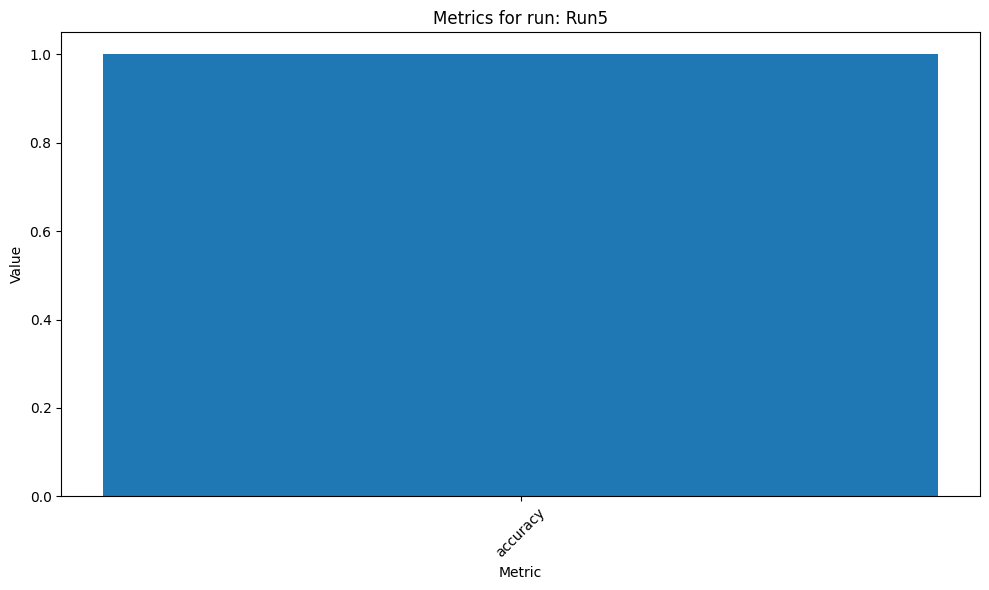

In [87]:

run = fetch_run(EXPERIMENT_NAME, RUN_NAME)

if run.data:
    # Display the metrics from the run
    for key, value in run.data.metrics.items():
        print(f"{key}: {value}")


# Get the metrics from the run
metrics = run.data.metrics
# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values())
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Metrics for run: {}'.format(run.info.run_name))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Load model artifact and predict on given features

In [96]:
data = run.data
model_uri = f"{run.info.artifact_uri}/{MODEL_ARTIFACT_NAME}"

print(model_uri)

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(model_uri)


features =  [[4.4, 2.9, 1.4, 0.2], [1,2,3,4]]

predictions = loaded_model.predict(pd.DataFrame(features))

print(predictions)

mlflow-artifacts:/652831916149125192/7cb42a35b6e64eb7a3e17383fbcb70ae/artifacts/my_iris_model


[0 2]
